In [1]:
import torch
from torch_geometric.datasets import TUDataset, Entities
import torch
# from tqdm import tqdm
from torch_geometric.utils import to_networkx
from torch_geometric.utils.convert import from_networkx
import networkx as nx
from gnn import GNN
import matplotlib.pyplot as plt
import os
import numpy as np
from gnn import GNN
from torch_geometric.utils import to_dense_adj, dense_to_sparse
from torch_geometric.data import Data, Batch
import plotly.express as px
import matplotlib.colors as mcolors
import random
import pickle
from utils import draw_graph, get_average_phi
import plotly.graph_objects as go
from tqdm.notebook import tqdm

if not os.path.isdir("figures"): os.mkdir("figures")

import plotly.io as pio
pio.templates.default = "simple_white"

In [2]:
atom_indices = {
    0: "C",
    1: "N",
    2: "O",
    3: "F",
    4: "I",
    5: "Cl",
    6: "Br",
}

edge_indices = {
    0: "aromatic",
    1: "single",
    2: "double",
    3: "triple",
}

atom_colors = {
    0: "#9b5fe0",
    1: "#16a4d8",
    2: "#60dbe8",
    3: "#efdf48",
    4: "#f9a52c",
    5: "#d64e11",
    6: "#8bd346",
}

In [3]:
# model_path = "models/Shapes_model.pth"
# with open("data/Shapes/dataset.pkl", "rb") as f: dataset = pickle.load(f)
# molecules = False

# model_path = "models/MUTAG_model_smaller.pth"
# dataset = TUDataset(root='data/TUDatascet', name='MUTAG')
# molecules = True

# model_path = "models/OurMotifs_model_mean.pth"
# with open("data/OurMotifs/dataset.pkl", "rb") as f: dataset = pickle.load(f)
# molecules = False

model_path = "models/Is_Acyclic_model.pth"
with open("data/Is_Acyclic/dataset.pkl", "rb") as f: dataset = pickle.load(f)
molecules = False

node_0_connected: tensor(True)
node_1_connected: tensor(True)
node_2_connected: tensor(True)


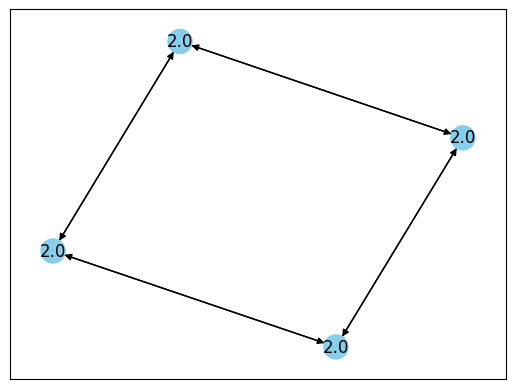

In [4]:
draw_graph(data=dataset[0])
A = torch.squeeze(to_dense_adj(dataset[0].edge_index))
for i in range(A.shape[0]-1):
    c = sum(A[i][j] + A[j][i] for j in range(i+1,A.shape[0])) >= 1
    print(f"node_{i}_connected:", c)
    if not c:
        print(A[i, :], A[i, :])

In [5]:
num_node_features = dataset[0].x.shape[1]
node_colors = {i:c for i,c in enumerate(random.choices(list(mcolors.CSS4_COLORS.values()), k=num_node_features))}
node_colors

{0: '#008B8B'}

In [6]:
import os
os.listdir("models/")

['OurMotifs_model_mean.pth',
 'OurMotifs_model.pth',
 'Is_Acyclic_model.pth',
 'Shapes_model.pth',
 'MUTAG_model.pth',
 'wrapped_MUTAG_model.pth']

In [7]:
nn = torch.load(model_path)
nn.double()
nn.eval()

GNN(
  (layers): ModuleDict(
    (Conv_0): SAGEConv(1, 4, aggr=mean)
    (Conv_0_Relu): ReLU()
    (Conv_1): SAGEConv(4, 4, aggr=mean)
    (Conv_1_Relu): ReLU()
    (Aggregation): MeanAggregation()
    (Lin_0): Linear(in_features=4, out_features=4, bias=True)
    (Lin_0_Relu): ReLU()
    (Output): Linear(in_features=4, out_features=2, bias=True)
  )
)

In [8]:
phi = get_average_phi(dataset, nn, "Aggregation")

In [9]:
with open("solutions.pkl", "rb") as f:
    solutions = pickle.load(f)

NN output given explanation [ 27.11192005 -38.07490598]


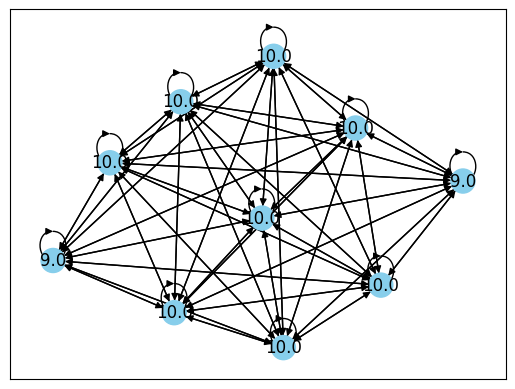

In [10]:
# index = "Final"
# A = np.load(f"./solutions/A_{index}.npy")
# X = np.load(f"./solutions/X_{index}.npy")
final = solutions[-1]
A = final["A"]
X = final["X"]


fig, _ = draw_graph(A, X, label_dict=(atom_indices if molecules else None), color_dict=(atom_colors if molecules else None))
fig.show()

exp_output = nn.forwardXA(X, A).detach().numpy().squeeze()
print("NN output given explanation", exp_output)


In [11]:
plt.close()

1


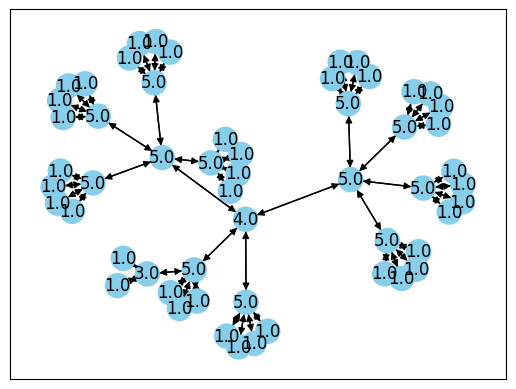

1


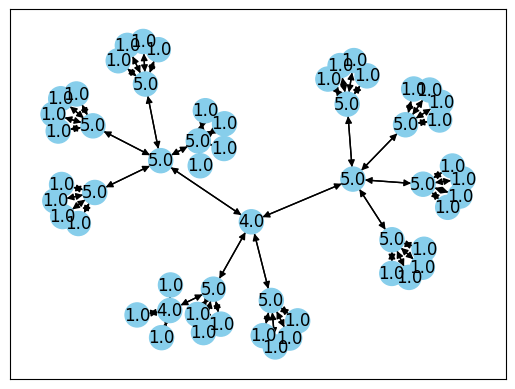

1


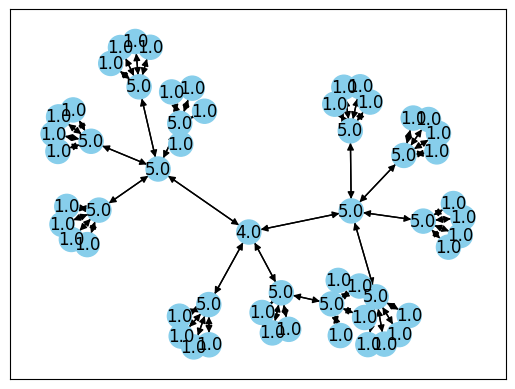

1


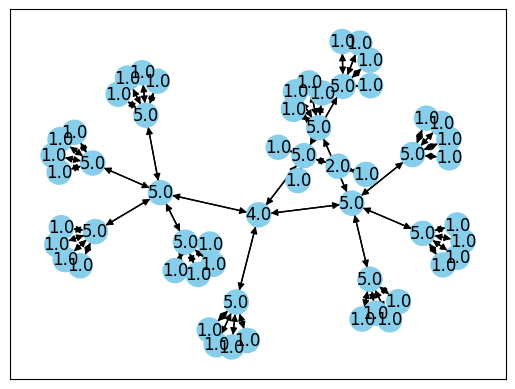

1


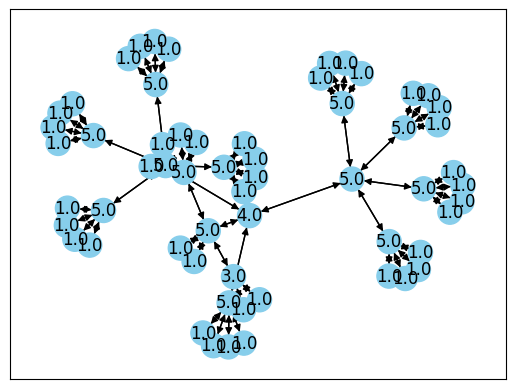

1


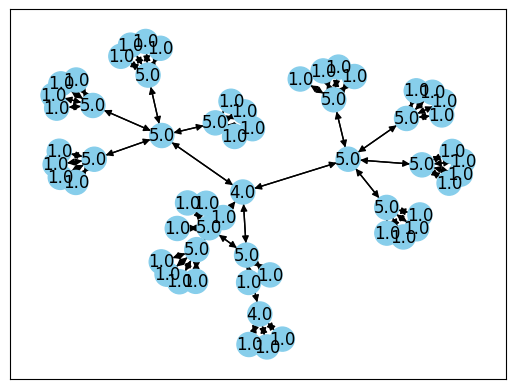

1


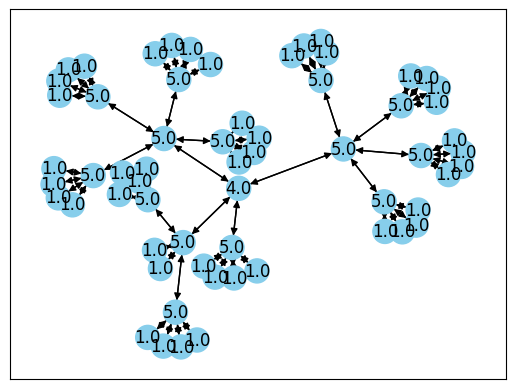

1


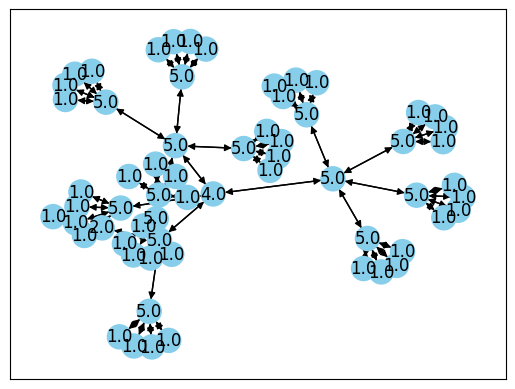

1


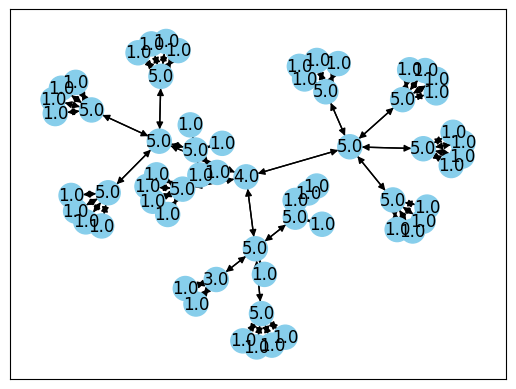

1


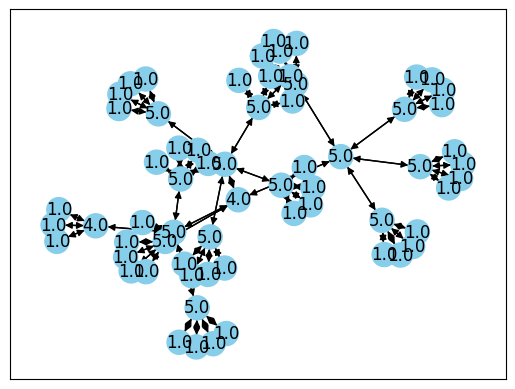

In [12]:
for data in dataset[-10:]:
    print(data.y)
    fig, ax = draw_graph(to_dense_adj(data.edge_index)[0].detach().numpy(), data.x.detach().numpy(), color_dict=(atom_colors if molecules else None), label_dict=(atom_indices if molecules else None))
    plt.show()
    fig.clear()

In [13]:
from gnn import GNN
class WrappedGNN(torch.nn.Module):
    def __init__(self, gnn):
        super().__init__()
        self.gnn = gnn
    
    def forward(self, x, edge_index):
        return self.gnn.forward(Data(x=x, edge_index=edge_index))
    
wrapped_nn = WrappedGNN(nn)
wrapped_nn.double()

torch.save(nn, "models/wrapped_MUTAG_model.pth")

/opt/anaconda3/envs/gurobi/lib/python3.8/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


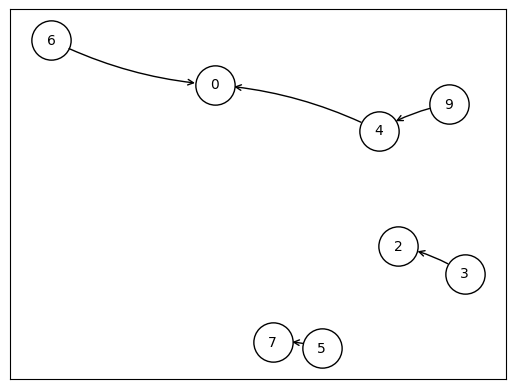

In [14]:
from torch_geometric.data import Data, DataLoader
from torch_geometric.explain import Explainer, PGExplainer, GNNExplainer

loader = DataLoader(dataset, batch_size=1, shuffle=True)

explainer = Explainer(
    model=wrapped_nn,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='log_probs',
    ),
    # Include only the top k most important edges:
    threshold_config=dict(threshold_type='topk', value=5),
)

# Generate the explanation for a particular graph:
explanation = explainer(x=torch.Tensor(X).double(), edge_index=dense_to_sparse(torch.Tensor(A))[0])
# print(explanation.edge_mask)
# print(explanation.node_mask)

explanation.visualize_graph()

In [16]:
import networkx.algorithms.isomorphism as iso
hypothesis_graph = nx.Graph()
# hypothesis_graph_nodes = [(0, {"label": 0}), (1, {"label": 0}), (2, {"label": 0}), (3, {"label": 0}), (4, {"label": 0}), (5, {"label": 0})]
# hypothesis_graph_nodes += [(6, {"label": 0}), (7, {"label": 0}), (8, {"label": 0}), (9, {"label": 0}), (10, {"label": 0}), (11, {"label": 0})]
hypothesis_graph_nodes = [(0, {"label": 4})]
hypothesis_graph.add_nodes_from(hypothesis_graph_nodes)
# hypothesis_graph.add_edges_from([(i,i+1) for i in range(0, 5)] + [(5,0)])
# hypothesis_graph.add_edges_from([(i,i+1) for i in range(6, 11)] + [(11,6)])
# hypothesis_graph.add_edge(0, 1)
# hypothesis_graph.add_edge(1, 2)
num_classes = len(set([int(d.y) for d in dataset]))
total = [0 for _ in range(num_classes)]
total_matched = [0 for _ in range(num_classes)]
for data in tqdm(dataset):
    # print(data.x)
    data_graph = to_networkx(data, to_undirected=True)
    x_indices = np.argmax(data.x.detach().numpy(), axis=1)
    if 4 in x_indices: print("hello")
    label_mapping = dict(zip(range(data.x.shape[0]), x_indices)) # dict(zip(range(X.shape[0]), map(label_dict.get, x_indices)))
    nx.set_node_attributes(data_graph, label_mapping, "label")
    GM = iso.GraphMatcher(data_graph,hypothesis_graph, node_match=iso.categorical_node_match('label',None))
    total[data.y] += 1
    total_matched[data.y] += GM.subgraph_is_isomorphic()
print(total, total_matched, [a/b for a,b in zip(total_matched, total)])

# print({key: torch.eye(7)[value["label"]] for key, value in hypothesis_graph_nodes})
# nx.set_node_attributes(hypothesis_graph, {key: torch.eye(7)[value["label"]] for key, value in hypothesis_graph_nodes}, name="label")

# for data in tqdm(dataset):
#     data.x = data.x.double()
#     original_prediction = nn(data).detach().numpy().squeeze()
#     del data.edge_weight
#     del data.batch

#     data_graph = to_networkx(data, to_undirected=True)
#     label_mapping = dict(zip(range(data.x.shape[0]), list(data.x)))
#     nx.set_node_attributes(data_graph, label_mapping, "label")
#     updated_graph = nx.union(data_graph, hypothesis_graph, rename=("h", "g"))
#     data = from_networkx(updated_graph, group_node_attrs=["label"])

#     # data.edge_index = torch.cat([data.edge_index, torch.Tensor([[random.choice(range(data.x.shape[0])), data.x.shape[0]]]).int().T], axis=1)
#     # data.x = torch.cat([data.x, torch.unsqueeze(torch.eye(data.x.shape[1])[4],axis=0)], axis=0)
#     new_prediction = nn(data).detach().numpy().squeeze()

#     print(original_prediction - new_prediction)
#     print("--")
# print(total, total_matched)

  0%|          | 0/533 [00:00<?, ?it/s]

[227, 306] [0, 0] [0.0, 0.0]


In [19]:
all_outputs = []
max_output_value, min_output_value = None, None
max_activation_value = -float("inf")
num_nodes = []

max_class = 0

similarities = []

for i, data in enumerate(dataset):
    data.x = data.x.double()
    outputs = nn(data).detach().numpy()
    # if outputs[0][0] < -15: print(i)
    all_outputs.append(outputs)
    if max_output_value is None: max_output_value, min_output_value = -float("inf")*np.ones_like(outputs), float("inf")*np.ones_like(outputs)
    max_output_value = np.max(np.stack([max_output_value, outputs]),axis=0)
    min_output_value = np.min(np.stack([min_output_value, outputs]),axis=0)

    all_layer_outputs = nn.get_all_layer_outputs(data)
    embedding = dict(all_layer_outputs)["Aggregation"].detach().numpy()
    l1_similarity = sum(np.abs((embedding[0] - phi[max_class])))
    squared_l2_similarity = sum((embedding[0] - phi[max_class])*(embedding[0] - phi[max_class]))
    cosine_similarity = np.dot(embedding[0], phi[max_class])/(np.linalg.norm(embedding[0])*np.linalg.norm(phi[max_class]))
    dot_product = np.dot(embedding[0], phi[max_class])
    similarities.append({"L1": l1_similarity, "Squared L2": squared_l2_similarity, "L2": np.sqrt(squared_l2_similarity),"Cosine": cosine_similarity, "Dot Product": dot_product, "Class": int(data.y)})

    all_activations = [output for _, output in all_layer_outputs]
    max_activation_value = max(max_activation_value, max(float(torch.max(torch.abs(activation))) for activation in all_activations))
    num_nodes.append(data.num_nodes)
print("Max Absolute Activation Value:", max_activation_value)
print("Min Class Output Value:", min_output_value)
print("Max Class Output Value:", max_output_value)
import pandas as pd
similarities = pd.DataFrame.from_records(similarities)
for similarity in similarities.columns:
    if similarity == "Class": continue
    px.violin(similarities, x=similarity, color="Class", color_discrete_map={0: "Red", 1: "Blue"}, title=f"{similarity} Similarity to Phi[{max_class}] of Class {max_class}", box=True).show()
px.histogram(num_nodes, title="Number of Nodes").show()


all_outputs = np.concatenate(all_outputs, axis=0)
px.scatter(x=list(all_outputs[:, 0])+[exp_output[0]], y=list(all_outputs[:, 1])+[exp_output[1]], color=[str(int(d.y)) for d in dataset]+["2"], color_discrete_map={"0": "Red", "1": "Blue", "2": "Green"}).show()
for i in range(all_outputs.shape[-1]):
    fig = px.histogram(all_outputs[:, i], title=f"Class {i} Logit Distribution", color=[int(d.y) for d in dataset], color_discrete_map={0: "Red", 1: "Blue"})

    fig.add_annotation(
        text="Explanation Value",
        x=exp_output[i],
        y=0,  # Adjust the y-coordinate as needed
        showarrow=True,
        arrowhead=2,
        ax=0,  # Adjust the text label's position relative to the point
        font=dict(
            size=14,
        )
    )

    fig.update_layout(
        xaxis_title="Logit Value",
        yaxis_title="Count",
    )

    fig.update_xaxes(
        range=[min(min(all_outputs[:, i]), exp_output[i])-2, max(max(all_outputs[:, i]), exp_output[i])+2]
    )    

    fig.show()

Max Absolute Activation Value: 334.18144385656666
Min Class Output Value: [[-332.3315958   -31.70735712]]
Max Class Output Value: [[ 18.49241706 334.18144386]]


In [ ]:
folder = "figures"
# for i in range(14):
#     A = np.load(f"./solutions/A_{i}.npy")
#     X = np.load(f"./solutions/X_{i}.npy")
for i, sol in enumerate(solutions):
    A = sol["A"]
    X = sol["X"]

    fig, _ = draw_graph(A, X, label_dict=(atom_indices if molecules else None), color_dict=(atom_colors if molecules else None))
    
    plt.savefig(folder + "/file%02d.png" % i)
    plt.close()

import subprocess
import glob
os.chdir(folder)
subprocess.call([
    'ffmpeg', '-framerate', '4', '-i', 'file%02d.png', '-r', '30', '-pix_fmt', 'yuv420p', '-y',
    'graph_steps.mp4'
])
for file_name in glob.glob("*.png"):
    os.remove(file_name)
os.chdir("..")